# Weather models : 3D parameters

The aim of this notebook is to indicate how to read the 3D data from the large-mesh french weather model called 'ARPEGE' (spatial resolution of 0.1°).

Per geographic zone ('NW' for North-West of France and 'SE' for South-East of France) and day, you have the weather model run of 00h with range forecasts from 00h to 24h. The time step is different according to days : it is 1h from 0h to 12h and rises to 3h after 12h (from 12h to 24h of range forecasts).

Finally, the 3D data are stored in 2 different GRIB files, according to the vertical levels:
* height levels (*height* in the file name) : 20, 100, 500, 875, 1375, 2000 and 3000 m
* isobar levels (*isobar* in the file name) : 1000, 950, 925, 850, 700, 600 and 500 hPa

The parameters are as follows:
* height levels (*height* in the file name) : pressure (in Pa)
* isobar levels (*isobar* in the file name) : temperature (in K), pseudo-adiabatic potential temperature of the wet bulb** (in K), relative humidity (in %), wind speed (in m.s<sup>-1</sup>), wind direction (in °), U and V wind components** (in m.s<sup>-1</sup>), vertical velocity** (in Pa.s<sup>-1</sup>), geopotential** (in m<sup>2</sup>.s<sup>-2</sup>)

For more information, cf [documentation](https://meteofrance.github.io/meteonet/english/data/weather-models/).

When you open a GRIB file with the library xarray, a new associated file of type .idx is created. 

/!\ : Some files in the model files are incomplete/corrupted. It comes from the database of our corporation. There are archiving anomalies. We are working on a new version of MeteoNet and will take into account these anomalies. Meanwhile, you can detect these anomalies by checking the file sizes. For a given file category (zone, level, model type), the files must have exactly the same size. So if some files are smaller than the other one, then these files have anomalies. This has been reported in kaggle in this discussion https://www.kaggle.com/katerpillar/meteonet/discussion/157206 and in Github (https://github.com/meteofrance/meteonet/issues/14). 

** : Physical sense of variables
* *pseudo-adiabatic potential temperature of the wet bulb : temperature affected to an air particle brought back to its condensation level. It is about a near-conversative parameter. It allows to follow the state of an air particle in a satured atmosphere and then allows to follow the evolution of a perturbation, depression (or a satured air mass). For example, this parameter at 850hPa is very useful to know the depression structure and to follow its evolution.*
* *horizontal wind speed components, U : from west to east and V : from south to north.* 
* *vertical velocity : vertical speed; the displacement is expressed in Pa (in meteorology, the vertical levels are often expressed in isobar levels, cf weather_models_explanations.md for more details); The higher the height is, the lower the pressure is. If the vertical velocity is positive, there is an upward current (ex : the earth surface is warmed by the sun). The opposite corresponds to a downdraft (ex : an cold air mass passes above a warmer ground).*
* *geopotential : it is used to compute the pressure and takes account the local gravity variations of the Earth. The height of the geopotential is interesting in meteorology : it allows to get the constant pressure heights. A high geopotential (pressure levels have high heights) is often associated to an anticyclone and a low geopotential (pressure levels have low heights) corresponds to a depression.*

In [1]:
import meteonet_toolbox.user_configuration
import xarray as xr
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import datetime as dt

User is not known. If you experiment some problems with path for library please add the specific path in `user_configuration.py` module


## Parameters definition

Select the area, model, date, level, parameter and time step you want to study :

In [2]:
zone = "SE"     #geographic zone (NW or SE)
level = 'isobar'              #vertical level (height or isobar)
date = dt.datetime(2018, 5, 1,0,0) # Day example 
#parameter name in the file (cf cells below to know the parameter names -> exploration of metadata)
if level == 'isobar':
    param = 'w'
    level_name = 'isobaricInhPa'     #name of the vertical level    
else:
    param = 'pres'
    level_name = 'heightAboveGround'
time_step = 0                #index for the studied time step (cf plot example below)

## Loading data using parameters

In [3]:
fname = "../../data_samples/weather_models/arpege_3D_%s_%s_%s.grib" % (level,zone,date.strftime('%Y%m%d%H%M%S'))
data = xr.open_dataset(fname, engine='cfgrib')  #data loading

## Quick field visualisation

<IPython.core.display.Javascript object>


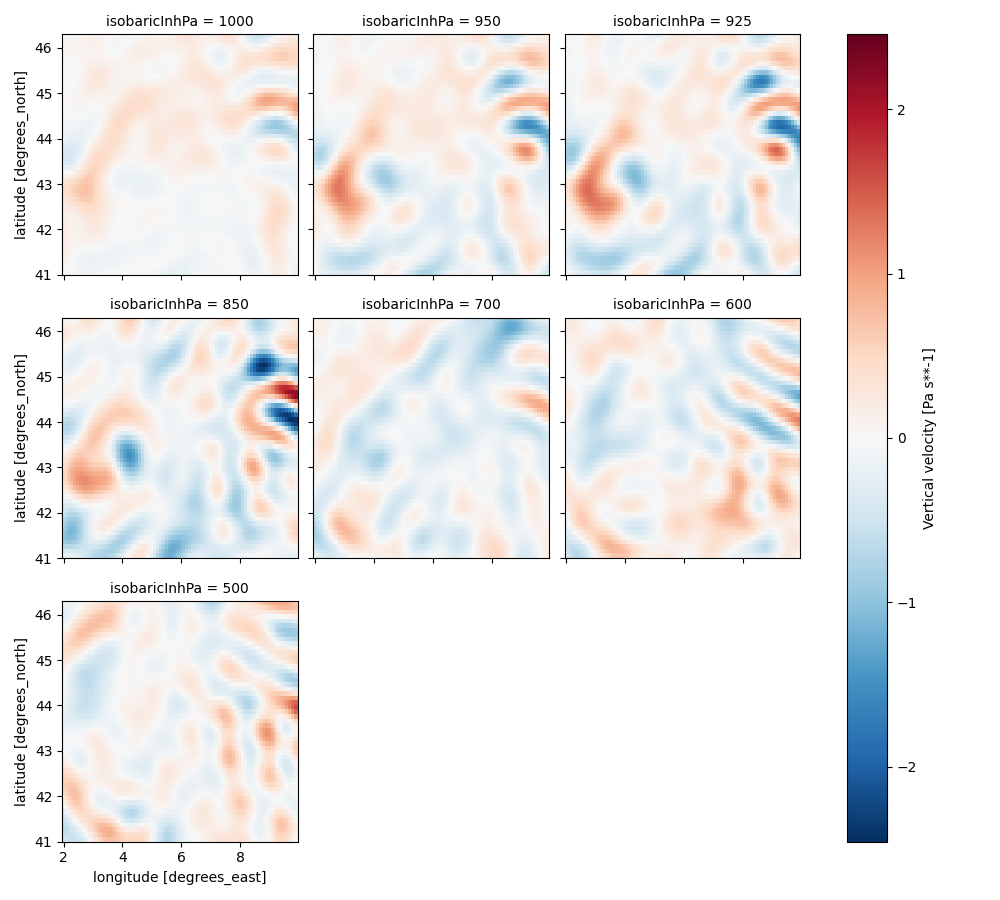

In [4]:
data.isel(step=time_step)[param].plot(x="longitude",y="latitude",col=level_name,col_wrap=3)

# Exploration of metadata

Overview of the data:

In [ ]:
print(data)

Get the information about coordinates (latitude and longitude):

In [ ]:
coord = 'longitude'
data[coord]

In [ ]:
data[coord].units

In [ ]:
data[coord].values

Get the information about the run date and the different range forecasts:

In [ ]:
run_date = data['time']
#run_date.values     #get the values
run_date

In [ ]:
range_forecasts_dates = data['valid_time']
range_forecasts_dates

Get the information about the vertical level:

In [ ]:
info_level = data[level_name]
level_vals=info_level.values     #get the values
info_level

Get the information about one parameter: 
the parameter names in the GRIB file are indicated in the field *Data variables* (cf print(data) above)

In [ ]:
d = data[param]     #param : parameter name defined at the beginning of the Notebook 
d_vals=d.values     #get the values
###examples to get the information from attributes
#d.units                      #unit
#d.long_name                      #long name
d

The structure of the parameter (4 dimensions):
* number of steps or range forecasts
* number of vertical levels
* number of points in latitude
* number of points in longitude

In [ ]:
d_vals.shape

## Plotting data with Cartopy

Plot the parameter values for 1 given time and level step with Cartopy:

In [ ]:
from meteonet_toolbox.constant import DOMAINS
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [ ]:
#index for the studied level step (cf plot example below)
level_step = 2               

In [ ]:
#coordinates of study zone boundaries
lllat = DOMAINS[zone]['lry']  #lower left latitude
urlat = DOMAINS[zone]['uly']  #upper right latitude
lllon = DOMAINS[zone]['ulx']  #lower left longitude
urlon = DOMAINS[zone]['lrx']  #upper right longitude
extent = [lllon, urlon, lllat, urlat]

In [ ]:
fig=plt.figure(figsize=(9,10))

# Select projection
ax = plt.axes(projection=ccrs.PlateCarree())

#plot the data and the background map (coastlines and borders)
img = ax.imshow(d_vals[time_step,level_step,:,:], interpolation='none', origin='upper', extent=extent)
ax.coastlines(resolution='50m', linewidth=1)
ax.add_feature(cfeature.BORDERS.with_scale('50m'))

plt.colorbar(img, orientation= 'horizontal').set_label(d.long_name+ ' (in '+d.units+ ')')
plt.title("ARPEGE model - "+ str(level_vals[level_step])+ " "+ info_level.units + " - "  +str(d['valid_time'].values[time_step])+" - " +zone + " zone")
plt.show()